# Mosaicking Pipeline

This example showcases a possible extension of the `eogrow.pipelines.FeaturesPipeline`.

The proposed `MosaickingPipeline` serves as a preprocessing step of downloaded data:
1. Loads downloaded data
2. Filters it according to data validity and cloud mask
3. Creates a temporal mosaic
4. Calculates the desired NDIs
5. Saves the processed data

The pipeline is included as a fully stand-alone implementation (does not build upon `FeaturesPipeline`). It serves as a customizable alternative to server-side mosaicking.

In [57]:
import os
import eogrow
import matplotlib.pyplot as plt
from eogrow.pipelines.download import DownloadPipeline
from eolearn.core import EOPatch, FeatureType
from eolearn.visualization import PlotConfig

from pipeline import MosaickingPipeline

### Prepare manager configs

In [79]:
managers = dict(
    logging=dict(
        manager="eogrow.core.logging.LoggingManager",
        show_logs=True,
        save_logs=True,
    ),
    area=dict(
        manager="eogrow.core.area.CustomGridAreaManager",
        grid_filename="aoi_grid.geojson",
        name_column="name",
    ),
    storage=dict(
        manager="eogrow.core.storage.StorageManager",
        project_folder=os.path.join(".", "project-data"),
        structure={"data": "data", "median_mosaic": "median-mosaic", "ndvi_mosaic": "ndvi-mosaic"},
    ),
)

## Download data

In [42]:
download_config = dict(
    output_folder_key="data",
    bands_feature_name="bands",
    data_collection="SENTINEL2_L2A",
    bands=["B02", "B03", "B04", "B08"],
    additional_data=[(FeatureType.MASK, "dataMask"), (FeatureType.MASK, "CLM")],
    time_period=["Q1", "2019"],
    time_difference=120,
    resolution=10,
    maxcc=0.7,  # Filter out completely useless frames
    use_dn=True,
)
download_config.update(managers)

download_pipeline = DownloadPipeline.from_raw_config(download_config)

In [43]:
download_pipeline.run()

INFO eogrow.core.pipeline:227: Running DownloadPipeline
INFO eogrow.utils.ray:24: No Ray cluster found, will not use Ray.
INFO eogrow.core.area.base:108: Loading grid from cache/CustomGridAreaManager_aoi_grid.gpkg
INFO eogrow.utils.ray:24: No Ray cluster found, will not use Ray.
INFO eogrow.core.pipeline:177: Starting EOExecutor for 1 EOPatches


100%|██████████| 1/1 [00:04<00:00,  4.24s/it]

INFO eogrow.core.pipeline:199: EOExecutor finished with 1 / 1 success rate
INFO eogrow.core.pipeline:208: Saved EOExecution report to /home/zluksic/Documents/Projects/eo-grow-examples/mosaicking-pipeline/project-data/logs/2023-01-24T12-01-40Z-DownloadPipeline-f335fa9bb4/eoexecution-report-2023_01_24-13_01_40/report.html
INFO eogrow.core.pipeline:239: Pipeline finished successfully!


### Check downloaded data

In [64]:
patch = EOPatch.load(os.path.join(".", "project-data", "data", "patch0"))
patch.timestamp

[datetime.datetime(2019, 1, 4, 7, 48, 37),
 datetime.datetime(2019, 1, 9, 7, 48, 49),
 datetime.datetime(2019, 1, 19, 7, 48, 36),
 datetime.datetime(2019, 1, 24, 7, 48, 39),
 datetime.datetime(2019, 2, 3, 7, 48, 40),
 datetime.datetime(2019, 2, 8, 7, 48, 36),
 datetime.datetime(2019, 2, 13, 7, 48, 39),
 datetime.datetime(2019, 2, 18, 7, 48, 36),
 datetime.datetime(2019, 2, 23, 7, 49, 38),
 datetime.datetime(2019, 3, 5, 7, 55, 53),
 datetime.datetime(2019, 3, 10, 8, 3, 53)]

In [65]:
patch.get_features()

[(<FeatureType.DATA: 'data'>, 'bands'),
 (<FeatureType.MASK: 'mask'>, 'dataMask'),
 (<FeatureType.MASK: 'mask'>, 'CLM'),
 (<FeatureType.BBOX: 'bbox'>, None),
 (<FeatureType.TIMESTAMP: 'timestamp'>, None)]

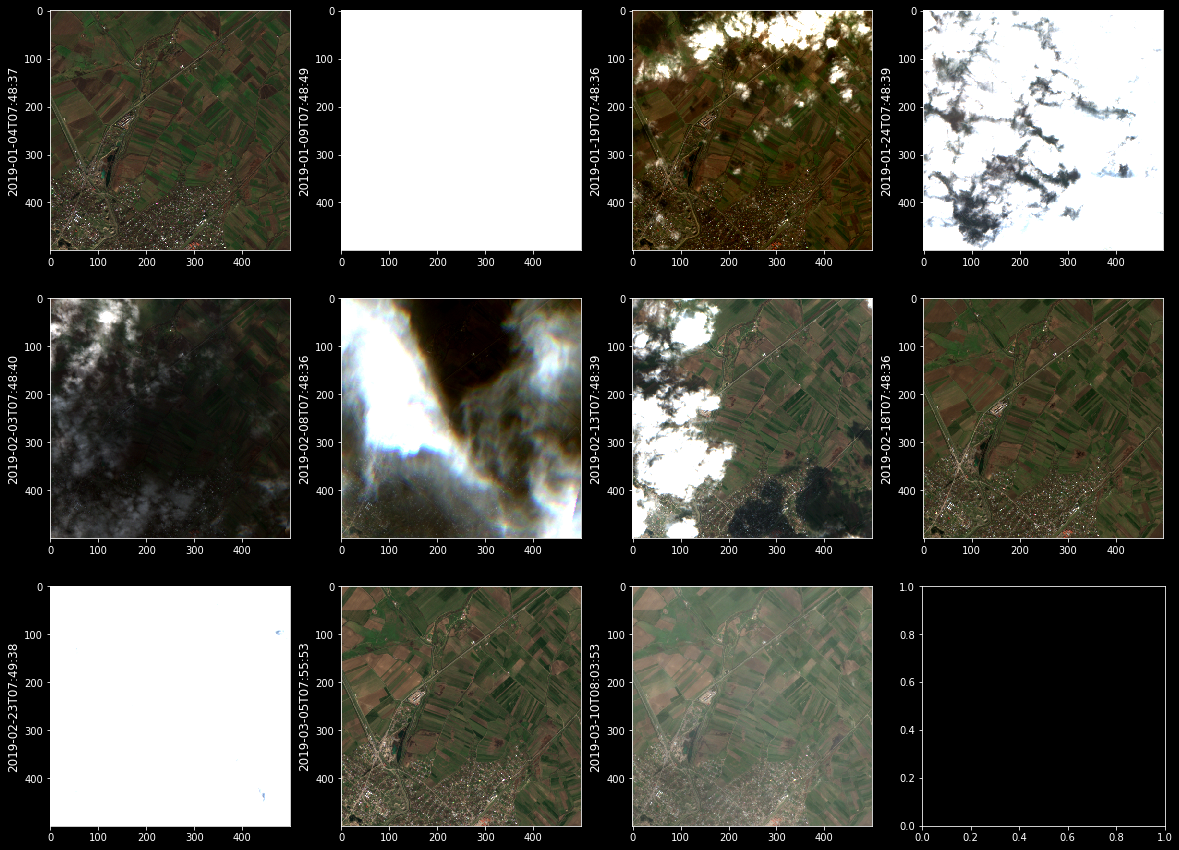

In [52]:
_, axes = plt.subplots(3, 4, figsize=(20, 15))
patch.plot((FeatureType.DATA, "bands"), rgb=[2,1,0], config=PlotConfig(rgb_factor=0.00035), axes=axes);

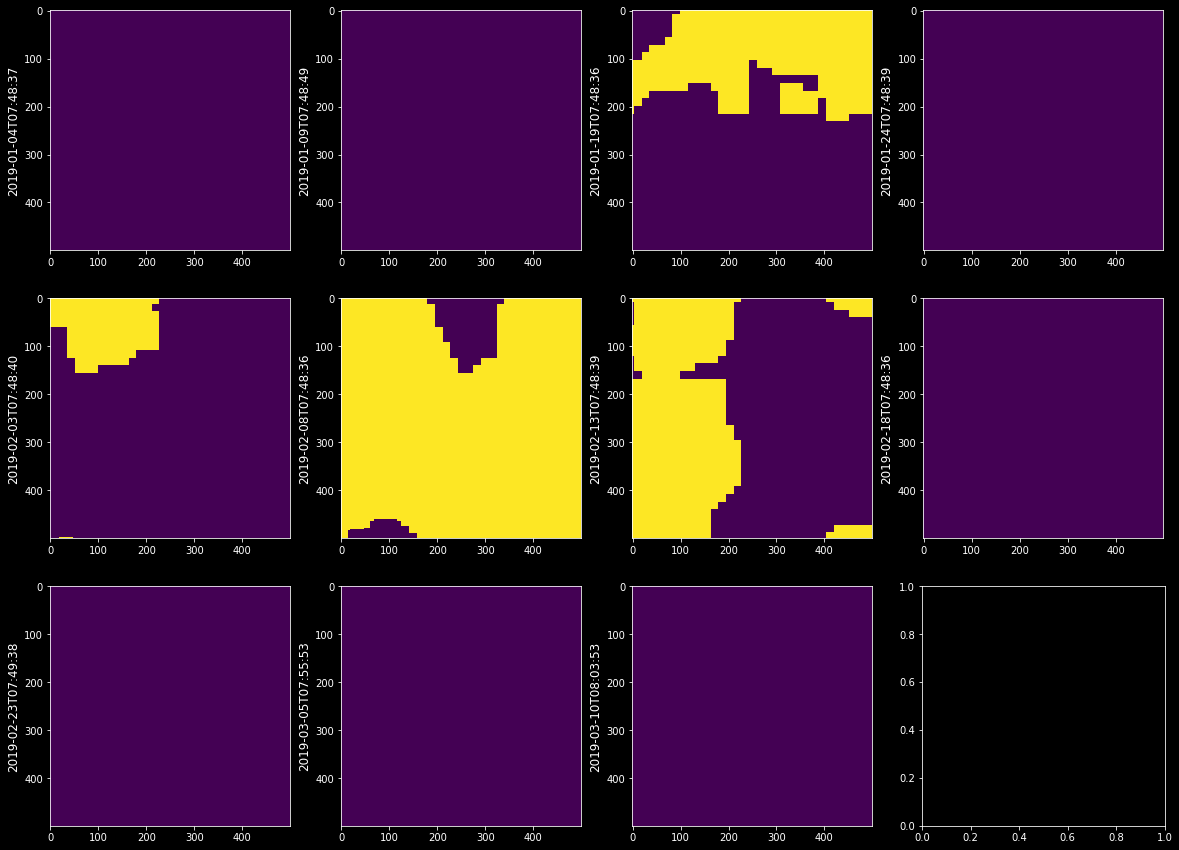

In [56]:
_, axes = plt.subplots(3, 4, figsize=(20, 15))
patch.plot((FeatureType.MASK, "CLM"), axes=axes);
# The fully white images actually have a CLM full of 1, but it is displayed as dark blue here since it is the only value

## Median value mosaicking

In [87]:
mean_mosaicking_config = dict(
    input_folder_key="data",
    output_folder_key="median_mosaic",
    bands_feature_name="bands",
    data_preparation=dict(
        cloud_mask_feature_name= "CLM",
        valid_data_feature_name= "dataMask",
        validity_threshold= 0.5
    ),
    mosaicking=dict(
        time_period=["Q1", 2019],
        n_mosaics=3
    ),
    output_feature_name="mosaicked_bands",
)
mean_mosaicking_config.update(managers)

mosaicking_pipeline = MosaickingPipeline.from_raw_config(mean_mosaicking_config)

In [88]:
mosaicking_pipeline.run()

INFO eogrow.core.pipeline:227: Running MosaickingPipeline
INFO eogrow.core.area.base:108: Loading grid from cache/CustomGridAreaManager_aoi_grid.gpkg
INFO eogrow.utils.ray:24: No Ray cluster found, will not use Ray.
INFO eogrow.core.pipeline:177: Starting EOExecutor for 1 EOPatches


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

INFO eogrow.core.pipeline:199: EOExecutor finished with 1 / 1 success rate
INFO eogrow.core.pipeline:208: Saved EOExecution report to /home/zluksic/Documents/Projects/eo-grow-examples/mosaicking-pipeline/project-data/logs/2023-01-24T12-24-44Z-MosaickingPipeline-c57a1a7d83/eoexecution-report-2023_01_24-13_24_44/report.html
INFO eogrow.core.pipeline:239: Pipeline finished successfully!


### Check the mosaic

In [102]:
patch = EOPatch.load(os.path.join(".", "project-data", "median-mosaic", "patch0"))
patch.timestamp

[datetime.datetime(2019, 1, 16, 0, 0),
 datetime.datetime(2019, 2, 15, 0, 0),
 datetime.datetime(2019, 3, 17, 0, 0)]

In [103]:
patch.get_features()

[(<FeatureType.DATA: 'data'>, 'mosaicked_bands'),
 (<FeatureType.BBOX: 'bbox'>, None),
 (<FeatureType.TIMESTAMP: 'timestamp'>, None)]

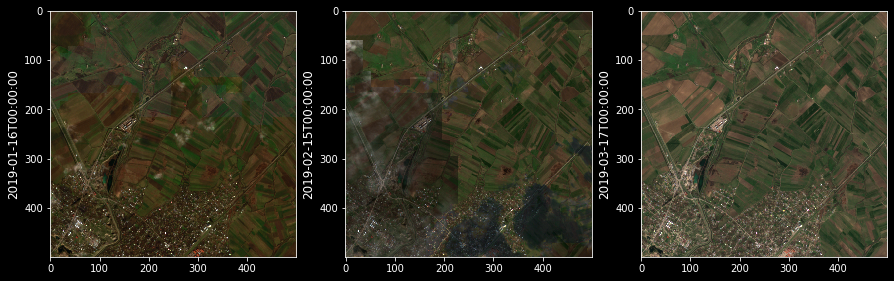

In [104]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
patch.plot((FeatureType.DATA, "mosaicked_bands"), rgb=[2,1,0], config=PlotConfig(rgb_factor=0.00035), axes=axes);

## Max NDVI value mosaicking

In [107]:
ndvi_mosaicking_config = mean_mosaicking_config.copy()
ndvi_mosaicking_config["output_folder_key"] = "ndvi_mosaic"
ndvi_mosaicking_config["mosaicking"]["max_ndi_indices"] = (3, 2)  # set to use NDVI = NDI(B08, B04)
ndvi_mosaicking_pipeline = MosaickingPipeline.from_raw_config(ndvi_mosaicking_config)

In [108]:
ndvi_mosaicking_pipeline.run()

INFO eogrow.core.pipeline:227: Running MosaickingPipeline
INFO eogrow.core.area.base:108: Loading grid from cache/CustomGridAreaManager_aoi_grid.gpkg
INFO eogrow.utils.ray:24: No Ray cluster found, will not use Ray.
INFO eogrow.core.pipeline:177: Starting EOExecutor for 1 EOPatches


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

INFO eogrow.core.pipeline:199: EOExecutor finished with 1 / 1 success rate
INFO eogrow.core.pipeline:208: Saved EOExecution report to /home/zluksic/Documents/Projects/eo-grow-examples/mosaicking-pipeline/project-data/logs/2023-01-24T12-27-34Z-MosaickingPipeline-fcd6b33af9/eoexecution-report-2023_01_24-13_27_34/report.html
INFO eogrow.core.pipeline:239: Pipeline finished successfully!


In [109]:
patch = EOPatch.load(os.path.join(".", "project-data", "ndvi-mosaic", "patch0"))
patch.timestamp

[datetime.datetime(2019, 1, 16, 0, 0),
 datetime.datetime(2019, 2, 15, 0, 0),
 datetime.datetime(2019, 3, 17, 0, 0)]

In [110]:
patch.get_features()  #NDVI is not included, one can obtain it via `ndis` parameter of pipeline

[(<FeatureType.DATA: 'data'>, 'mosaicked_bands'),
 (<FeatureType.BBOX: 'bbox'>, None),
 (<FeatureType.TIMESTAMP: 'timestamp'>, None)]

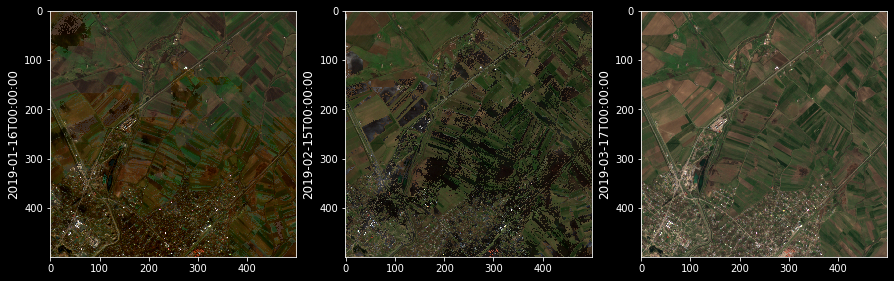

In [111]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
patch.plot((FeatureType.DATA, "mosaicked_bands"), rgb=[2,1,0], config=PlotConfig(rgb_factor=0.00035), axes=axes);